### Задание
*На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру*

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

In [83]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

Подгрузим сырые данные и посмотрим на них:

In [84]:
data = pd.read_excel('.\AB_Test_Results.xlsx') 
data.sample(10)


,USER_ID,VARIANT_NAME,REVENUE
1892,1803,variant,0.0
9214,8234,variant,0.0
2204,6334,control,0.0
9907,4509,control,0.0
8011,2691,variant,0.0
2077,3683,variant,0.0
2072,8399,control,0.0
1251,252,variant,0.0
7953,9450,variant,0.0
1162,7661,variant,0.0


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Видим, что пустых значений нет, наша метрика является числовой величиной(float), и общий размер выборки составляет 10000

Раз у нас есть поле с id пользователей, стоит проверить корректность сплитования по попаданию пользователя только в одну из групп в процессе сбора данных:

In [86]:
split_check = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
split_check.sample(10)


,USER_ID,VARIANT_NAME
4379,6914,2
2315,3610,2
5137,8139,1
724,1144,2
227,367,1
165,266,1
3766,5932,1
133,218,2
2282,3565,1
1711,2662,2


Видим, что часть юзеров попали в обе тестовые группы по колонке **VARIANT_NAME** , нам нужно будет отсеять всех пользователей с уникальными значениями >1 (то есть все 2-ки)

In [87]:
bad_split_mask = split_check.query('VARIANT_NAME > 1')
bad_split_mask

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [88]:
data_clean = data[~data.USER_ID.isin(bad_split_mask.USER_ID)].sort_values('USER_ID')
data_clean.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique}).query('VARIANT_NAME > 1')

,USER_ID,VARIANT_NAME


Отсеяли 1541 строк в датасете, теперь все записи уникальны по user_id

In [89]:
data_clean.VARIANT_NAME.value_counts()

variant    3044
control    3026
Name: VARIANT_NAME, dtype: int64

Выборки между двумя группами отличаются по размеру незначительно, можно сравнивать без дополнительной обработки.

In [90]:
control = data_clean.query('VARIANT_NAME == "control"')
test = data_clean.query('VARIANT_NAME == "variant"')

In [91]:
control.drop(['USER_ID'],axis=1).describe()

,REVENUE
count,3026.000000
mean,0.155506
std,3.708620
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,196.010000


In [92]:
test.drop(['USER_ID'],axis=1).describe()

,REVENUE
count,3044.000000
mean,0.058909
std,0.760344
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,23.040000


Есть заметная разница между средними по группам и большая разница по максимумам, стоит посмотреть распределение и выбросы.

In [93]:
stats.shapiro(test.REVENUE)

ShapiroResult(statistic=0.051010727882385254, pvalue=0.0)

In [94]:
stats.shapiro(control.REVENUE)

ShapiroResult(statistic=0.017641663551330566, pvalue=0.0)

Тест Шапиро(хорошо подходит здесь, так как выборки меньше 10000) показывает **ненормальность распределения** метрики в обоих группах(p-value = 0 , что значительно меньше статзначимости для гипотезы о нормальном распределении)

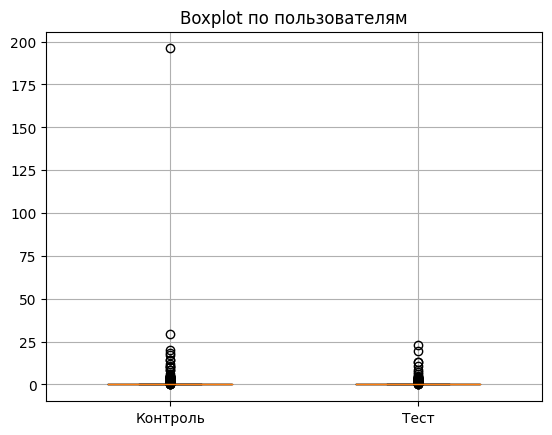

In [95]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Стоит отсеять большой единичный выброс в контрольной группе по абсолютному значению, чтобы проще было сравнить общую статистистику

In [96]:
control2 = control[control.REVENUE < 50.0]
print(f'максимальное значение в группах \n контрольная: {control2.REVENUE.max()} \n тестовая: {test.REVENUE.max()}')
print(f'стандартное отклонение в группах \n контрольная: {control2.REVENUE.std(ddof=1)} \n тестовая: {test.REVENUE.std(ddof=1)}')

максимальное значение в группах 
 контрольная: 29.32 
 тестовая: 23.04
стандартное отклонение в группах 
 контрольная: 1.0341013932625318 
 тестовая: 0.7603442366395241


Осталось сравнить нашу метрику в двух разных выборках, которые:
1)Независимы друг от друга
2)Распределены ненормально
3)Количество выборок для сравнения = 2

Здесь подойдет *криттерий Манна-Уитни*

In [97]:
stats.mannwhitneyu(control2.REVENUE, test.REVENUE, alternative= "greater", axis=0)

MannwhitneyuResult(statistic=4619788.0, pvalue=0.1429921154309774)

При альтернативной гипотезе , что доход в тестовой группе больше, чем в контрольной, получаем p-value 0.14 в пользу нулевой гипотезы. То есть, **статистической значимости не обнаружено**.  
Однако, стоит проверить мощность нашего теста, и насколько мы вообще можем полагаться на результаты эксперимента с таким числом пользователей(особенно после отсеивания)

d = (M1 – M2) / S_pooled , где  

$S_{pooled} = \sqrt{(S^2_{1}+S^2_{2})/2}$

In [98]:
M1 = control2.REVENUE.mean()

M2 = test.REVENUE.mean()

M1,M2


(0.09076033057851242, 0.05890932982917214)

In [99]:
S1 = control2.REVENUE.std(ddof=1)

S2 = test.REVENUE.std(ddof=1)

S1,S2

(1.0341013932625318, 0.7603442366395241)

In [100]:
S_pooled = np.sqrt((S1**2 + S2 **2)/ 2)
S_pooled

0.9076037267823579

In [101]:
effect = float((M1-M2)/ S_pooled)
effect

0.03509351031673111

Получаем очень маленький эффект по оценке стандартного отклонения, что означает сложность его обнаружения при малом числе наблюдений.

In [102]:
print(len(control2),len(test))
n = min(len(control2),len(test))
n,len(test)/len(control2)


3025 3044


(3025, 1.006280991735537)

In [103]:
import statsmodels.stats.power as an_stat

our_power = an_stat.TTestIndPower().solve_power(effect_size=effect,
                                                 nobs1=n, ratio=1.0,
                                                 alpha=0.05, 
                                                 power=None)

print(f"Наш тест точен на  {our_power*100:.0f}% ({our_power})")

Наш тест точен на  28% (0.276243059355489)


Видим, что вероятность найти разницу, если она реально существует, все примерно 30% , что далеко до общепринятой мощности в 80%

In [104]:
needed_size = an_stat.TTestIndPower().solve_power(effect_size=effect,
                                                 nobs1=None, ratio=1.0,
                                                 alpha=0.05, 
                                                 power=0.8)
needed_size

12747.226783904223

### Рекомендации по результатам теста:
1. Проверить систему сплитования и настройки A/B теста, сделать проверочный A/A тест.
2. Чтобы дать уверенный ответ по данной гипотезе, число пользователей в  группах рекомендуется набрать не меньше 12000, отталкиваясь от полученной разницы в метриках.
3. Пока принимается решение о повторе эксперимента по этой гипотезе, не выкатывать изменения, так как  статистической разницы в  сторону увеличения выручки выявлено не было.

### Дополнительная часть
Чтобы собрать дополнительные данные для дальнейшего дизайна жкспериментов, можно сравнить выборки только среди платящих пользователей.

In [106]:
arppu_control = control2.query('REVENUE > 0')
arppu_control.sample(5)

,USER_ID,VARIANT_NAME,REVENUE
9327,8076,control,1.66
6378,124,control,1.25
6081,487,control,4.33
7050,3845,control,2.16
2974,5063,control,0.02


In [107]:
arppu_test = test.query('REVENUE > 0')
arppu_test.sample(5)

,USER_ID,VARIANT_NAME,REVENUE
8227,932,variant,1.30
6451,1339,variant,4.52
8838,7157,variant,0.02
7221,9021,variant,1.25
5751,4995,variant,2.50


In [122]:
arppu_control.REVENUE.describe()

count    53.000000
mean      5.180189
std       5.942771
min       0.020000
25%       1.560000
50%       2.990000
75%       4.980000
max      29.320000
Name: REVENUE, dtype: float64

In [121]:
arppu_test.REVENUE.describe()

count    43.000000
mean      4.170233
std       4.932851
min       0.020000
25%       1.250000
50%       2.720000
75%       4.270000
max      23.040000
Name: REVENUE, dtype: float64

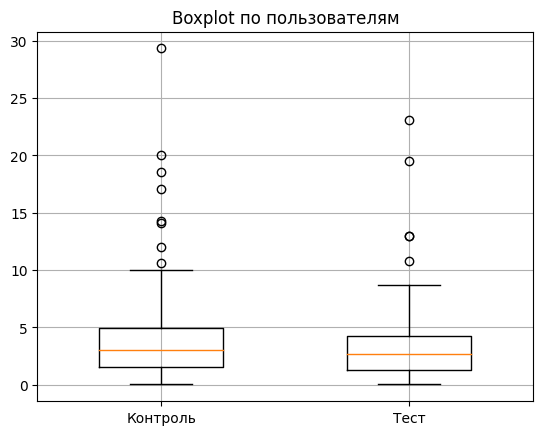

In [112]:
plt.boxplot([arppu_control.REVENUE.values,arppu_test.REVENUE.values],
            labels=['Контроль','Тест'],
            widths=0.5)
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

In [115]:
stats.mannwhitneyu(arppu_control.REVENUE, arppu_test.REVENUE, alternative= "two-sided", axis=0)

MannwhitneyuResult(statistic=1249.0, pvalue=0.4218148352342157)

In [116]:
def calc_SizeEffect(X:pd.Series,Y:pd.Series) ->float:
    M1 = X.values.mean()
    M2 = Y.values.mean()
    S1 = X.values.std(ddof=1)
    S2 = Y.values.std(ddof=1)
    S_pooled = np.sqrt((S1**2 + S2 **2)/ 2)
    effect = float((M1-M2)/ S_pooled)
    return effect

payers_eff = calc_SizeEffect(arppu_control.REVENUE,arppu_test.REVENUE)
payers_eff

0.1849327939575381

In [117]:
payers_power = an_stat.TTestIndPower().solve_power(effect_size=payers_eff,
                                                 nobs1=min(len(arppu_control),len(arppu_test)),
                                                 ratio=1.0,
                                                 alpha=0.05, 
                                                 power=None)
payers_power

0.1355124990195734

Как видим, хоть оценочный эффект разницы между выборками стал больше, он все равно достаточно мал для нашего небольшого числа платящих пользователей(всего меньше 100 человек), чтобы тест по мощности считался некорректным по мощности

In [123]:
an_stat.TTestIndPower().solve_power(effect_size=payers_eff,
                                                 nobs1=None, ratio=1.0,
                                                 alpha=0.05, 
                                                 power=0.8)


459.95817723301593

Таким образом, если мы захотим протестировать изменения схожей значимости(по мнению нашей команды), который затрагивали бы только уже повторных покупателей, то мы могли бы сделать относительно небольшой тест по 500 человек в каждой группе.